In [2]:
import pandas as pd
import keras
import tensorflow as tf
import numpy as np
from keras import layers
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers
from keras.preprocessing import *

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
import os
os.getcwd()

'/content'

In [5]:
os.listdir()

['.config', 'drive', 'sample_data']

In [13]:
df_train = pd.read_csv("drive/MyDrive/train_cleaned_vec.csv", index_col = 0)
df_test = pd.read_csv("drive/MyDrive/test_cleaned_vec.csv", index_col = 0)

dfs = [df_train, df_test]
df = pd.concat(dfs)


In [14]:
# Shuffle data to remove any bias present in order
df = df.sample(frac = 1)

# Reset index and drop original index column
df = df.reset_index(drop = True)

df.head()

,label,text,label_str,tokenized_text,word_vector,doc_vector
0,2,biliary pancreatic metastases breast carcinoma...,digestive,"['biliary', 'pancreatic', 'metastases', 'breas...",[-0.71421003 -0.43195808 0.15991907 0.386262...,[-4.60017860e-01 8.57100934e-02 2.68247008e-...
1,5,gene human major histocompatibility complex cl...,pathological,"['gene', 'human', 'major', 'histocompatibility...",[-0.04018178 -0.11258222 0.2162807 0.040244...,[ 0.0501379 -0.10564893 0.19522364 -0.173172...
2,1,effect abdominal surgery serum concentration t...,neoplasms,"['effect', 'abdominal', 'surgery', 'serum', 'c...",[-0.9937201 0.13171172 -0.01576049 0.522078...,[-0.39013508 0.0248358 0.05966463 0.088042...
3,4,effect halothane isoflurane postischemic stunn...,cardiovascular,"['effect', 'halothane', 'isoflurane', 'postisc...",[-0.24769801 0.3850019 -0.13547665 0.090897...,[-0.18150187 0.27354786 -0.17195095 -0.015542...
4,1,fibromatous epulis dogs peripheral odontogenic...,neoplasms,"['fibromatous', 'epulis', 'dogs', 'peripheral'...",[ 0.15302294 -0.11429843 0.2625601 0.260906...,[ 0.25961468 0.06794935 0.14143008 -0.236263...


In [28]:
df['word_vector'][0]

'[-0.71421003 -0.43195808  0.15991907  0.38626274  0.04781558 -0.48157117\n  0.17861766  0.33395472 -0.53779346 -0.1454402   0.10876191 -0.14460744\n -0.87054515 -0.06958377  0.05641678 -0.05247179  0.18397798 -1.6283635\n -0.3470311  -1.2217605   0.07419684  0.25058287  0.36215112  0.41909254\n  0.02291591  0.02597334  0.13878934 -0.35179588 -0.24361397  0.27152073\n  0.08842931 -0.13643901  0.36934707 -0.27618927 -0.12014078  0.9117457\n  0.24535997 -0.47187874 -0.66877437 -0.931308   -0.33712864 -0.40584818\n  0.28837156 -0.08660394  0.1047089  -0.17412001 -0.4747374  -0.10787129\n  0.00564343  0.39726052  0.01543204 -0.36989698 -0.31879357  0.26676497\n -0.5299637   0.02592342  0.78011805  0.27708447 -0.4254185   0.30106464\n -0.17721532 -0.07419155 -0.36921838 -0.10730512 -0.5324708  -0.2543051\n  0.26878995  0.25399098 -0.7810068  -0.27223763  0.14206327  0.33873582\n -0.06327583  0.050341    0.7625775   0.03082247  0.10018466  0.10603174\n -0.5392508   0.18368293 -0.27566543 -0.

## Word2Vec and Doc2Vec

In [51]:
from gensim.models import Word2Vec

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=df['tokenized_text'].tolist(), vector_size=100, window=5, min_count=2, workers=4)

# Create a function to average Word2Vec vectors for each document
def average_word_vectors(words, model, vocabulary, num_features):
    feature_vector = np.zeros((num_features,), dtype="float64")
    nwords = 0

    for word in words:
        if word in vocabulary:
            nwords += 1
            feature_vector = np.add(feature_vector, model.wv[word])

    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
    return feature_vector

# Apply function to each row in the DataFrame
vocabulary = set(word2vec_model.wv.index_to_key)
df['word_vec'] = df['tokenized_text'].apply(lambda x: average_word_vectors(x, word2vec_model, vocabulary, 100))


In [52]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# Tagging documents
tagged_data = [TaggedDocument(words=_d, tags=[str(i)]) for i, _d in enumerate(df['tokenized_text'])]

# Train Doc2Vec model
doc2vec_model = Doc2Vec(tagged_data, vector_size=100, window=5, min_count=2, workers=4)

# Save the vectors to DataFrame
df['doc_vec'] = [doc2vec_model.dv[str(i)] for i in range(len(df))]


In [16]:
target = df["label_str"]

# one hot encode target
y = pd.get_dummies(target).values

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=20000)
tokenizer.fit_on_texts(list(df['text']))
tokenized_texts = tokenizer.texts_to_sequences(df['text'])
X = tf.keras.preprocessing.sequence.pad_sequences(tokenized_texts)

In [49]:
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

Shape of X: (14438, 1)
Shape of y: (14438, 5)


In [55]:
X_word_vec = np.array(list(df['word_vector']))
X_doc_vec = np.array(list(df['doc_vector']))

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [56]:
X_word_vec.shape

(14438,)

In [57]:
X_doc_vec.shape

(14438,)

In [59]:
    # Stack arrays correctly
    X = np.array(list(df['doc_vector']))
    print("New shape of X:", X.shape) ## Shouldn't be one dimensional??

New shape of X: (14438,)


## RNN #1: Doc2Vec

In [36]:
# Convert the list of vectors into a single numpy array
X = np.stack(df['doc_vec'].values)

# Add an explicit timestep dimension
X = X.reshape((X.shape[0], 1, X.shape[1]))
print("Shape of X after reshaping:", X.shape)

Shape of X after reshaping: (14438, 1, 100)


In [41]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Label encoding
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(df['label_str'])
# Convert labels to categorical
y = to_categorical(encoded_labels)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [42]:
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)

Shape of X_train: (11550, 1, 100)
Shape of y_train: (11550, 5)


In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

# Initialize the model
model = Sequential()

# Adding LSTM layer
model.add(LSTM(64, input_shape=(1, 100)))  # Shape [timesteps, features]

# Adding dropout for regularization
model.add(Dropout(0.5))

# Adding a Dense layer for classification
model.add(Dense(5, activation='softmax'))  # 5 classes

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model architecture
model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 5)                 325       
                                                                 
Total params: 42565 (166.27 KB)
Trainable params: 42565 (166.27 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [45]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)


Epoch 1/20


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 235, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential_5' (type Sequential).
    
    Input 0 of layer "lstm" is incompatible with the layer: expected ndim=3, found ndim=1. Full shape received: (None,)
    
    Call arguments received by layer 'sequential_5' (type Sequential):
      • inputs=tf.Tensor(shape=(None,), dtype=string)
      • training=True
      • mask=None


In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, GlobalMaxPool1D
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_doc_vec, y, test_size=0.2)

# Create the model
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.25))
model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.25))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(5, activation='softmax'))  # 5 categories for the output layer

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


IndexError: tuple index out of range

In [35]:
print(type(df['doc_vec'].iloc[0]))
print(df['doc_vec'].iloc[0].shape)

<class 'numpy.ndarray'>
(100,)


In [22]:
print("Shape of Doc2Vec/Word2Vec vectors:", df['doc_vector'][0].shape)


AttributeError: 'str' object has no attribute 'shape'

In [23]:
df['doc_vector'][0]

'[-4.60017860e-01  8.57100934e-02  2.68247008e-01 -5.71715571e-02\n  1.35846525e-01 -3.58661532e-01 -2.75348267e-03  3.34813958e-03\n -1.00350320e-01 -1.77536979e-01  2.37339046e-02 -1.91271324e-02\n -1.97960496e-01 -1.08921185e-01 -2.68634576e-02 -9.91437957e-02\n  2.78562456e-02 -4.31421816e-01 -3.19513530e-02 -2.60830998e-01\n  2.93511134e-02  9.45286453e-02 -3.12892050e-02  2.18811423e-01\n -6.65868223e-02  2.67233640e-01  8.53709951e-02 -1.02302238e-01\n -1.20329395e-01 -8.96077901e-02  2.89456666e-01  4.79149148e-02\n -3.57673950e-02  9.47562139e-03  2.11157233e-01  1.80187523e-01\n -3.16780321e-02 -1.99381828e-01  7.70340487e-02 -2.44257390e-01\n  1.07234091e-01 -1.97756261e-01  1.42752826e-01  5.79903251e-04\n -9.24960524e-03 -1.28767803e-01 -2.13733032e-01  4.23730761e-02\n -2.60556433e-02  7.91492239e-02 -5.34485318e-02 -5.68576977e-02\n -3.60285081e-02  8.87881070e-02 -1.47176623e-01 -1.00596510e-01\n  7.89248943e-02  1.64050400e-01 -1.19142547e-01  1.82021618e-01\n  6.69809

In [26]:
type(df['doc_vector'][0])

str

In [20]:
type(X_train)

numpy.ndarray

In [ ]:
from sklearn.model_selection import train_test_split
from nltk import word_tokenize


data = df['text'].map(nltk.word_tokenize).values
total_vocabulary = set(word.lower() for text in data for word in text)  # set created from nested comprehension

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# create model
model = Sequential()

embedding_size = 128
model.add(Embedding(len(total_vocabulary), embedding_size))
model.add(LSTM(25, return_sequences=True))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.25))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(5, activation='softmax'))  # use 5 because we have 5 categories

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary() # check the shape


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 128)         4460416   
                                                                 
 lstm_1 (LSTM)               (None, None, 25)          15400     
                                                                 
 global_max_pooling1d_1 (Gl  (None, 25)                0         
 obalMaxPooling1D)                                               
                                                                 
 dropout_3 (Dropout)         (None, 25)                0         
                                                                 
 dense_3 (Dense)             (None, 50)                1300      
                                                                 
 dropout_4 (Dropout)         (None, 50)                0         
                                                      

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# configure early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)

# train the model with early stopping
history = model.fit(X_train, y_train,
          epochs=10,
          batch_size=32,
          validation_split=0.1,
          callbacks=[early_stopping])

Epoch 1/10
325/325 [==============================] - 28s 78ms/step - loss: 1.3665 - accuracy: 0.4321 - val_loss: 1.1358 - val_accuracy: 0.5723
Epoch 2/10
325/325 [==============================] - 13s 39ms/step - loss: 1.0921 - accuracy: 0.5608 - val_loss: 1.0610 - val_accuracy: 0.5645
Epoch 3/10
325/325 [==============================] - 9s 27ms/step - loss: 0.9283 - accuracy: 0.6203 - val_loss: 1.0143 - val_accuracy: 0.5758
Epoch 4/10
325/325 [==============================] - 7s 23ms/step - loss: 0.8094 - accuracy: 0.6735 - val_loss: 1.1227 - val_accuracy: 0.5593
Epoch 5/10
325/325 [==============================] - 7s 21ms/step - loss: 0.7213 - accuracy: 0.7142 - val_loss: 1.1650 - val_accuracy: 0.5619
Epoch 6/10
325/325 [==============================] - 6s 18ms/step - loss: 0.6359 - accuracy: 0.7512 - val_loss: 1.1985 - val_accuracy: 0.5593
Epoch 7/10
325/325 [==============================] - 5s 16ms/step - loss: 0.5949 - accuracy: 0.7605 - val_loss: 1.4177 - val_accuracy: 0.54

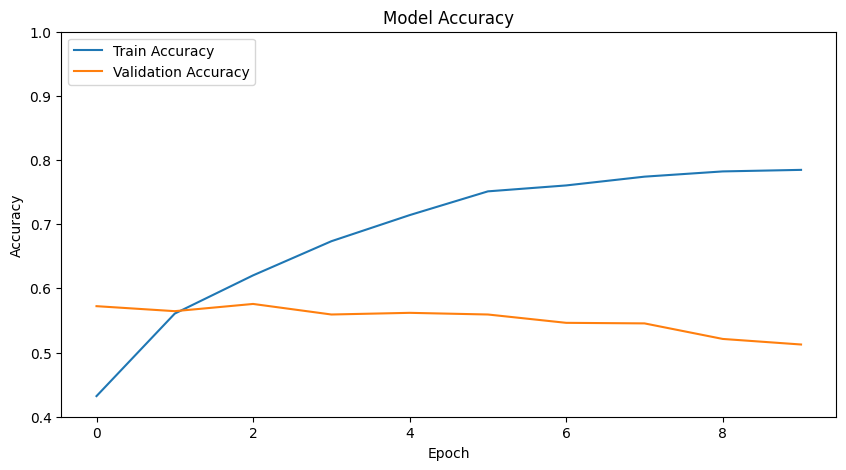

In [ ]:
import matplotlib.pyplot as plt

# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.ylim([0.4,1])
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

In [ ]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

91/91 [==============================] - 1s 7ms/step - loss: 1.7063 - accuracy: 0.4976
Test Loss: 1.7062660455703735
Test Accuracy: 0.49757617712020874


## XGBoost

In [ ]:
df.head()

,label,text,label_str,tokenized_text,word_vector,doc_vector
0,5,tissue changes around loose prostheses canine ...,pathological,"['tissue', 'changes', 'around', 'loose', 'pros...",[ 0.05476083 -0.03229698 0.17104799 0.033172...,[ 0.21682046 -0.15752031 0.20830779 -0.117360...
1,1,neuropeptide neuron specific enolase levels be...,neoplasms,"['neuropeptide', 'neuron', 'specific', 'enolas...",[-0.56716686 0.14063118 -0.1405798 0.147050...,[-0.28650808 0.20193662 -0.30122852 -0.332502...
2,2,sexually transmitted diseases colon rectum anu...,digestive,"['sexually', 'transmitted', 'diseases', 'colon...",[-4.44717050e-01 -2.43615746e-01 -1.48011688e-...,[-0.6044732 -0.31054446 -0.07080523 0.155947...
3,1,lipolytic factors associated murine human canc...,neoplasms,"['lipolytic', 'factors', 'associated', 'murine...",[-0.4299487 -0.3027548 0.00997588 0.194334...,[-0.00296343 0.01876458 -0.06699752 -0.298283...
4,3,carotid restenosis predict increased risk late...,nervous,"['carotid', 'restenosis', 'predict', 'increase...",[-0.42303556 -0.1667321 -0.17955366 0.680879...,[ 0.05615142 -0.13514839 0.18133207 0.226112...


In [ ]:
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# text data and labels
texts = df['text']
labels = df['label']

labels = labels - 1

# split into train and test sets
texts_train, texts_test, labels_train, labels_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

# convert text data into numerical features using TF-IDF
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(texts_train)
X_test = vectorizer.transform(texts_test)

# train the XGBoost model
model = xgb.XGBClassifier(n_jobs=-1)
model.fit(X_train, labels_train)

# make predictions on the test set
predictions = model.predict(X_test)

# evaluate the model performance
accuracy = accuracy_score(labels_test, predictions)
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 49.13%


In [ ]:
from sklearn.model_selection import GridSearchCV

parameters = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

grid_search = GridSearchCV(xgb.XGBClassifier(n_jobs=-1), parameters, cv=3, scoring='accuracy')
grid_search.fit(X_train, labels_train)
print("Best parameters:", grid_search.best_params_)


Best parameters: {'learning_rate': 0.2, 'max_depth': 3}


## NB

In [47]:
import numpy as np

if isinstance(df['doc_vector'].iloc[0], np.ndarray):
    X = np.stack(df['doc_vector'].values)
else:
    X = np.array([np.array(vec) for vec in df['doc_vector']])

# Ensure X is two-dimensional
if X.ndim == 1:
    X = X.reshape(-1, 1)

print("Shape of X:", X.shape)  #  (n_samples, n_features)


Shape of X: (14438, 1)


In [48]:
# Print the first document vector to see its contents
print(df['doc_vector'].iloc[0])

# Check the type and length of the first document vector
print(type(df['doc_vector'].iloc[0]))
print(len(df['doc_vector'].iloc[0]))


[-4.60017860e-01  8.57100934e-02  2.68247008e-01 -5.71715571e-02
  1.35846525e-01 -3.58661532e-01 -2.75348267e-03  3.34813958e-03
 -1.00350320e-01 -1.77536979e-01  2.37339046e-02 -1.91271324e-02
 -1.97960496e-01 -1.08921185e-01 -2.68634576e-02 -9.91437957e-02
  2.78562456e-02 -4.31421816e-01 -3.19513530e-02 -2.60830998e-01
  2.93511134e-02  9.45286453e-02 -3.12892050e-02  2.18811423e-01
 -6.65868223e-02  2.67233640e-01  8.53709951e-02 -1.02302238e-01
 -1.20329395e-01 -8.96077901e-02  2.89456666e-01  4.79149148e-02
 -3.57673950e-02  9.47562139e-03  2.11157233e-01  1.80187523e-01
 -3.16780321e-02 -1.99381828e-01  7.70340487e-02 -2.44257390e-01
  1.07234091e-01 -1.97756261e-01  1.42752826e-01  5.79903251e-04
 -9.24960524e-03 -1.28767803e-01 -2.13733032e-01  4.23730761e-02
 -2.60556433e-02  7.91492239e-02 -5.34485318e-02 -5.68576977e-02
 -3.60285081e-02  8.87881070e-02 -1.47176623e-01 -1.00596510e-01
  7.89248943e-02  1.64050400e-01 -1.19142547e-01  1.82021618e-01
  6.69809058e-02 -1.06300

In [54]:
X_word_vec.shape

(14438,)

In [53]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB  # Using GaussianNB because vectors are continuous

# if isinstance(df['doc_vector'].iloc[0], list):
#     df['doc_vector'] = df['doc_vector'].apply(np.array)

# X = np.stack(df['doc_vector'])
# labels = df['label'] - 1

# Split into train and test sets
X_train, X_test, labels_train, labels_test = train_test_split(X_doc_vec, labels, test_size=0.2, random_state=42)

# Using Gaussian Naive Bayes for continuous features
clf = GaussianNB()
clf.fit(X_train, labels_train)
labels_pred = clf.predict(X_test)
accuracy = accuracy_score(labels_test, labels_pred)
print(f"Accuracy with Doc2Vec: {accuracy}")


ValueError: Expected 2D array, got 1D array instead:
array=['[ 0.05074997 -0.14767276  0.26096857 -0.2264208  -0.10184981 -0.1586298\n  0.25368267  0.2588118  -0.2674932  -0.23498446  0.00722656 -0.28241152\n -0.47195038 -0.17192    -0.1534517  -0.05381459  0.24813157 -0.25696555\n  0.02748435 -0.54109323 -0.14625205  0.18226342  0.29901633  0.28128284\n -0.01727359  0.07601625  0.27040476  0.02174883 -0.19808088  0.05581201\n -0.1259698   0.09740011 -0.14125979 -0.07643371  0.03825907 -0.11314251\n -0.05602325 -0.2925168   0.11113138 -0.01365038  0.0622503  -0.04078443\n  0.19910419  0.09214031  0.11393238 -0.15275022 -0.12526442 -0.00995722\n -0.16314185  0.20563188 -0.10107744  0.22301179 -0.11139685 -0.10480183\n  0.0613134  -0.02448421  0.04081099 -0.06561599  0.06399746  0.3012396\n  0.02568728 -0.17122148 -0.11983866 -0.14602298 -0.32474974  0.09155659\n  0.16596901 -0.03814676 -0.01307526 -0.19504592  0.05178401  0.07326217\n  0.20578907 -0.18401769  0.23955569  0.18851034  0.34206787 -0.14978978\n -0.17475045  0.04277829 -0.1396745   0.13867018  0.1462572   0.07714903\n  0.07097194  0.14940296 -0.07022908  0.23035154  0.08135571  0.17846581\n  0.32198617  0.0819445  -0.13294274  0.04904745  0.47524124  0.08207286\n  0.22792862 -0.1295743  -0.03850533  0.00778205]'
 '[ 0.02905266  0.10419985  0.05420069 -0.09822991 -0.06039133 -0.25596425\n  0.10041346  0.3588229  -0.12243696 -0.0544883  -0.16501172 -0.260161\n  0.01287161  0.05090076 -0.16360383 -0.22864662  0.35892704 -0.26994282\n  0.02064096 -0.12841639  0.09025083  0.12656957 -0.01342742 -0.00079931\n -0.24013208 -0.00355176 -0.05356104 -0.06706296 -0.13451473 -0.01954658\n  0.17520694  0.05501365 -0.20436801  0.14886019 -0.04101271  0.27751896\n -0.03611879 -0.17104553 -0.0827995  -0.15917368  0.11775256  0.12048969\n  0.03027567 -0.22526239  0.04527505  0.01573483 -0.23648784 -0.00590546\n -0.0829755   0.07607973 -0.03604528 -0.03347798 -0.08944963  0.01259979\n -0.16540566  0.0311269  -0.07590539  0.00929498 -0.11691349 -0.02302365\n -0.01229574  0.0612215  -0.17604469 -0.08571003  0.07565343  0.16987452\n  0.10827934  0.15167843 -0.14026414  0.04093381 -0.03950407  0.03924954\n  0.12725091 -0.08577868  0.01713757  0.06925672  0.08510144 -0.05954417\n -0.11955948  0.09078885 -0.2382691   0.05098469  0.04297071  0.38637462\n -0.08080932 -0.00067459  0.0571936   0.13523571  0.10640737  0.04455409\n  0.12270972  0.07918639  0.0658592   0.2129842   0.19947007  0.14533865\n -0.02705489  0.05545777 -0.00516978  0.08328314]'
 '[-0.00184342  0.07682753 -0.04403769 -0.03299145  0.06642967 -0.03775458\n -0.09172948  0.1316448  -0.1959923   0.08034753 -0.21431258 -0.21021715\n -0.11913867  0.02307655 -0.13994578 -0.15883309  0.15722752 -0.09813318\n  0.08956243 -0.04224576  0.11158669  0.02507987 -0.05384455 -0.07307472\n  0.0016532   0.03003928  0.09065399 -0.1004805  -0.08608026  0.00224786\n  0.15059125 -0.05727639  0.02275564  0.178438    0.06600848  0.10996731\n  0.23015387 -0.17948702 -0.1236343  -0.07877681 -0.03533604 -0.08428578\n  0.04990663 -0.17240916 -0.17774574 -0.06579979 -0.05734013  0.1365828\n  0.05274823  0.03046697 -0.2070734  -0.24080157 -0.03885721 -0.09158559\n  0.05577639 -0.10828982  0.05570805 -0.03438009  0.2281452   0.05298734\n  0.0098244  -0.05336611 -0.02385661  0.01338687 -0.08565623 -0.13903391\n -0.03313754  0.00876073 -0.14633644 -0.07890502  0.0654462  -0.12070417\n -0.09603124 -0.09233177 -0.26606044  0.0537969  -0.08280735  0.00896144\n  0.01068306  0.0077868  -0.14492807 -0.12213048 -0.15816133  0.22608334\n -0.04053355  0.14793117  0.13822193  0.03051516  0.03216575  0.1423805\n  0.00385968  0.04813598 -0.10976435  0.25838047  0.2883241   0.0855516\n -0.010806    0.03778811 -0.02839387  0.03671562]'
 ...
 '[-0.04635765 -0.01974887  0.1132995   0.35003695 -0.27744773 -0.470371\n -0.0747568  -0.10189505  0.01313904 -0.20903891 -0.22534522  0.03832562\n -0.04283056 -0.04735664  0.14393789 -0.18857136  0.25774956  0.03316977\n  0.32956016 -0.3490203   0.05752704  0.01687339  0.26854336 -0.00830767\n  0.17678697  0.22571686 -0.45134476 -0.20668186 -0.2308156  -0.05449278\n  0.20202935  0.1315477   0.05524918 -0.09601566 -0.20598736  0.17092954\n -0.29959744  0.11385596 -0.11770359 -0.3769751   0.2569423   0.22324291\n -0.07422032 -0.20313273  0.07067428  0.07934821 -0.05941958  0.10749795\n  0.13127296  0.06461081  0.29793057  0.24262984 -0.16593821 -0.02191223\n -0.18109955  0.1866534   0.13816114  0.32825688 -0.1670799  -0.05317961\n -0.08266378  0.32305595  0.02480941 -0.13376889 -0.10754573 -0.08134131\n  0.1021114  -0.11169568 -0.1929243   0.01169572 -0.14472109  0.06123595\n -0.13866249  0.00536928  0.17701016 -0.06978099 -0.08607858 -0.04663779\n -0.30633056 -0.02128915 -0.04248565 -0.2672123  -0.29052174  0.31996372\n -0.03841503 -0.07909018  0.12556858 -0.01680851  0.23418595 -0.05091319\n  0.04866812  0.2717478  -0.14564124  0.2693883   0.30851874 -0.05719088\n  0.07631299 -0.177528   -0.1316505  -0.02904737]'
 '[-0.0859826  -0.11897627 -0.02020216 -0.12405029 -0.04035911 -0.4128925\n -0.2905227   0.65379953 -0.5227749   0.08164147 -0.20733857 -0.3081782\n -0.01041678  0.30403045  0.19282514 -0.5703923   0.08595621  0.1618531\n  0.0902702  -0.03352203  0.19934772  0.20172699  0.1928134   0.14523345\n -0.16877054 -0.55853283  0.34413442 -0.11887368 -0.17174369  0.00934622\n -0.24773028 -0.3331016  -0.28456527 -0.04424671  0.10184886  0.5259371\n  0.24757317 -0.10171935 -0.15862331  0.07449885 -0.19595134 -0.3767688\n -0.13677172  0.11572473  0.12504439  0.08375881  0.22788441 -0.27670342\n -0.29956326 -0.08160674  0.3721271  -0.15546341  0.07606206 -0.35583064\n  0.12846637  0.13659762  0.05113187  0.1395031  -0.24971308 -0.10681963\n -0.08146735  0.04839949  0.38852888  0.2720043   0.110049    0.7215912\n -0.25413743 -0.00932361 -0.40302616  0.15696962 -0.17058289 -0.1121515\n -0.23183584  0.1927266   0.10784925  0.31424683  0.03095745 -0.35727152\n -0.06075656  0.34250584  0.3815078   0.48687884 -0.47139898  0.04515869\n  0.07276262  0.14605694 -0.273931    0.22313556  0.48164326  0.10342523\n  0.19734484 -0.45967743  0.00517806  0.43641993  0.03243786 -0.06635033\n -0.02830148 -0.17442307 -0.13512233 -0.22107911]'
 '[ 0.18560201 -0.07038099  0.14184052 -0.09689533 -0.33158448 -0.36602882\n -0.17443159  0.30971372 -0.4193845  -0.24161285 -0.24099265 -0.39296886\n -0.3019678   0.19546902  0.04573846  0.40806356  0.14574783 -0.3765931\n  0.21857843 -0.3381901  -0.05439031  0.07850347  0.6093147   0.03384845\n  0.08602697  0.33383423 -0.16378427 -0.18326274 -0.11304313 -0.16024792\n  0.31223735  0.34555158  0.11345211  0.12307917 -0.0850381   0.02327216\n -0.407252   -0.54294455  0.06274461 -0.1817614  -0.00303042 -0.12751652\n -0.36850968 -0.3072111  -0.17507571 -0.06887086 -0.18139143 -0.03388661\n  0.06891908  0.25556818 -0.23072606 -0.35281643 -0.05096501  0.3185775\n -0.18443261  0.13646838  0.12406291 -0.12916698 -0.3704887   0.12386447\n -0.0587949   0.21924365  0.05091967  0.12918293  0.09294477  0.14645128\n  0.14334422  0.1344721  -0.0960048   0.09344538  0.365213    0.18947183\n  0.10350228  0.05623949  0.2167492  -0.02462362 -0.06577934 -0.29465982\n  0.04758209 -0.21722934 -0.01713965 -0.39300132 -0.01652469  0.21887156\n  0.07164889  0.1664251  -0.21511225  0.13219142  0.0918025   0.23731308\n -0.03508141  0.22771671 -0.28974906  0.03655268  0.00453024  0.14928822\n  0.21342953 -0.2966712   0.30857843  0.34256768]'].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()

# text data and labels
texts = df['text']
labels = df['label']

labels = labels - 1

# split into train and test sets
texts_train, texts_test, labels_train, labels_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

# convert text data
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(texts_train)
X_test = vectorizer.transform(texts_test)

clf.fit(X_train, labels_train)

MultinomialNB()

In [ ]:
clf.score(X_test, labels_test)

0.532202216066482

In [ ]:
from sklearn.metrics import classification_report

# Predicting the test set results
labels_pred = clf.predict(X_test)

# Generating the classification report
report = classification_report(labels_test, labels_pred)
print(report)

              precision    recall  f1-score   support

           0       0.75      0.66      0.70       607
           1       0.00      0.00      0.00       289
           2       0.48      0.03      0.05       355
           3       0.69      0.57      0.62       659
           4       0.42      0.77      0.54       978

    accuracy                           0.53      2888
   macro avg       0.47      0.40      0.38      2888
weighted avg       0.52      0.53      0.48      2888



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [60]:
%%shell
jupyter nbconvert --to html /content/drive/MyDrive/5400_models.ipynb

[NbConvertApp] Converting notebook /content/drive/MyDrive/5400_models.ipynb to html
[NbConvertApp] Writing 760347 bytes to /content/drive/MyDrive/5400_models.html
